# CNN - AE model validation

In [15]:
import csv
import os
import random
import numpy as np
from os import path
from sklearn import preprocessing
from sklearn.manifold.t_sne import TSNE
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

### Load data

In [16]:
# data directories
homedir = os.path.expanduser('~')
prjdir = 'Desktop/ehr-stratification'
datadir = 'data'
outdir = path.join(homedir, prjdir, datadir, 'mixed')
expdir = path.join(homedir, prjdir, datadir, 'experiments/mixed-2019-02-21-17-39-46')

# sub-sampling
n_samples = 5000

# read encoded vectors file and ordered medical record numbers
with open(path.join(expdir, 'mrns.csv')) as f:
    rd = csv.reader(f)
    mrns = [r[0] for r in rd]

with open(path.join(expdir, 'encoded_vect.csv')) as f:
    rd = csv.reader(f)
    encoded = [list(map(float, r)) for r in rd]

# sub-sample the collection
if n_samples is not None:
    idx = [i for i in range(len(mrns))]
    random.shuffle(idx)
    idx = idx[:n_samples]
    mrn_tmp = [mrns[i] for i in idx]
    enc_tmp = [encoded[i] for i in idx]
    mrns = mrn_tmp
    encoded = enc_tmp
set_mrns = set(mrns)
    
# read the vocabulary
with open(path.join(outdir, 'cohort-new_vocab.csv')) as f:    
    rd = csv.reader(f)
    next(rd)
    vocab = {r[1]: r[0] for r in rd}
len_vocab = len(vocab)

# read raw data
with open(path.join(outdir, 'cohort-new_ehr.csv')) as f:
    rd = csv.reader(f)
    raw_ehr = {}
    for r in rd:
        if r[0] in set_mrns:
            raw_ehr.setdefault(r[0], list()).extend(list(map(int, r[1::])))

# raw data (scaled) counts
scaler = StandardScaler()
data = raw_ehr.values()
raw_data = np.zeros((len(data), len_vocab))
for idx, token_list in enumerate(data):
    for t in token_list:
        raw_data[idx, t - 1] += 1

raw_data_scaled = scaler.fit_transform(raw_data)

# get the list of diagnosed diseases associated with mrns
with open(path.join(outdir, 'cohort-mrn_diseases.csv')) as f:
    rd = csv.reader(f)
    mrn_disease = {r[0]: r[1::] for r in rd if r[0] in set_mrns}

# evaluate potential disease classes

# (1) first diagnosis
gt_disease = {m: mrn_disease[m][0] for m in mrn_disease}

### Functions

>`svd_tfidf():` returns the SVD matrix of the TFIDF matrix of the raw ehr data;

>`silhouette_analysis():` hierarchical clustering on input data maximizing the Silhouette Index

>`single_plot():` one plot of all the clusters

>`nonoveralp_plot():` N different plots, one per cluster, with N = no. of clusters

> `outer_clustering_analysis():` external validation of clustering (entropy and Purity scores)

In [17]:
# analyze clustering using silhouette scores
def silhouette_analysis(data,
                        min_clu=2,
                        max_clu=10,
                        affinity_clu='euclidean'):
    # bound analysis range
    if min_clu < 2:
        min_clu = 2

    # run analysis for every clustering size
    best_silh = 0
    silh_scores = []
    for n in range(min_clu, max_clu, 1):
        hclu = AgglomerativeClustering(n_clusters=n,
                                       linkage='ward',
                                       affinity=affinity_clu)
        lbl = hclu.fit_predict(data).tolist()
        silh = silhouette_score(data, lbl)
        if silh < 0:
            break
        print(' -- {0}: {1:.3f}'.format(n, silh))
        silh_scores.append(silh)
        if silh > best_silh:
            best_silh = silh
            n_clu = n
            label = lbl
    try:
        print('No. of clusters: {0} -- Silhouette Score: {1:.3f}\n'.format(
            n_clu, best_silh))

    except UnboundLocalError:
        hclu = AgglomerativeClustering(n_clusters=min_clu,
                                       linkage='complete',
                                       affinity=affinity_clu)
        n_clu = min_clu
        label = hclu.fit_predict(data).tolist()
        print('No. of Clusters: {0} -- Silhouette Score: {1:.3f}\n'.format(
            n_clu, best_silh))

    return (n_clu, label, silh_scores)


# SVD matrix of the TFIDF matrix of the raw ehr data
def svd_tfidf(data, len_vocab, n_dimensions=200):
    # apply tf-idf
    tfidf = TfidfTransformer()
    tfidf_mtx = tfidf.fit_transform(data)

    # reduce size of the matrix
    svd = TruncatedSVD(n_components=n_dimensions)
    svd_mtx = svd.fit_transform(tfidf_mtx)

    return svd_mtx


# one plot with all the clusters
def single_plot(data, mrn_disease, colors):
    plt.figure(figsize=(20,10))
    for cl in set(mrn_disease):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j] == cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j] == cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j] == cl]
        plt.xticks([])
        plt.yticks([])
        plt.scatter(x, y, c=cols, label=cl)
    plt.legend()
 
    
# non-overlapping plots, one per cluster
def nonoverlap_plot(data, mrn_disease, colors):
    fig, ax = plt.subplots(len(set(mrn_disease)), 1, figsize=(20, 10*len(set(mrn_disease))))
    for idx, cl in enumerate(set(mrn_disease)):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j] == cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j] == cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j] == cl]
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        ax[idx].scatter(x, y, c=cols, label=cl)
        ax[idx].legend()

        
# external clustering analysis
def outer_clustering_analysis(data, gt_clu, affinity_clu='euclidean'):
    label_clu = sorted(set(gt_clu))

    # format clustering ground truth
    didx = {d: i for i, d in enumerate(label_clu)}
    idxd = {i:d for d, i in didx.items()}
    gt = [didx[d] for d in gt_clu]

    # validate cluster number
    if len(label_clu) == 1:
        n_clu = 3
    else:
        n_clu = len(label_clu)

    # run clustering
    hclust = AgglomerativeClustering(n_clusters=n_clu,
                                     linkage='ward',
                                     affinity=affinity_clu)
    clusters = hclust.fit_predict(data).tolist()

    # count cluster occurrences
    cnt_clu = [0] * n_clu
    for c in clusters:
        cnt_clu[c] += 1
    class_clu = [[0] * n_clu for _ in range(len(label_clu))]
    for i, gi in enumerate(gt):
        class_clu[gi][clusters[i]] += 1

    # compute entropy and purity
    entropy = 0
    purity = 0
    for j in range(0, max(clusters) + 1):
        en = 0
        pu = []
        for i in range(0, max(gt) + 1):
            pij = class_clu[i][j] / cnt_clu[j]
            pu.append(pij)
            if pij != 0:
                en += -(pij * np.log2(pij))
        max_pu = max(pu)
        ds_max = []
        for idx, p in enumerate(pu):
            if p == max_pu:
                ds_max.append(idxd[idx])
        print(
            'Cluster: {0} -- '
            'Entropy: {1:.3f}, '
            'Purity: {2:.3f}'.format(j, en, max_pu))
        for d in ds_max:
            print("Max(p) disease: {0}".format(d))
        cweight = cnt_clu[j] / len(gt)
        entropy += cweight * en
        purity += cweight * max_pu

    print('Average Entropy: {0:.2f}'.format(entropy))
    print('Average Purity: {0:.2f}'.format(purity))
    
    return clusters

## Run t-SNE for data visualization

In [18]:
# initialize T-SNE
tsne = TSNE(n_components=2, n_iter=7000, perplexity=40, random_state=42)

# plot colors
col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'powderblue', 'floralwhite', 'ghostwhite',
 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
 'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue', 'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin', 'snow', 'darkgray',
 'ivory']
colormap = [c for c in col_dict if c not in c_out]

In [19]:
# t-SNE on the CNN encoded vectors
# encoded = preprocessing.scale(encoded)
encoded_tsne = tsne.fit_transform(encoded).tolist()
print('Computed: CNN - AE encoded vectors t-SNE')

Computed: CNN - AE encoded vectors t-SNE


In [20]:
# t-SNE on the raw vectores
# raw_tsne = tsne.fit_transform(raw_data_scaled).tolist()
# print("Computed: raw count data t-SNE")

In [21]:
# t-SNE on the TF-IDF + SVD matrix
svd_mat = svd_tfidf(raw_data, len_vocab, n_dimensions = 100)
tfidf_tsne = tsne.fit_transform(svd_mat).tolist()
print("Computed: TF-IDF matrix t-SNE")

Computed: TF-IDF matrix t-SNE


In [22]:
# t-SNE on the LSTM encoded vectors
# lstm_encoded_tsne = tsne.fit_transform(lstm_encoded_vect).tolist()
# print("Computed LSTM encoded vectors t-SNE")

## t-SNE visualization and external clustering validation

In [23]:
# choose the disease classes: first_disease, oth_disease
disease_class_first = [gt_disease[m] for m in mrns]
disease_dict = {d: i for i, d in enumerate(set(disease_class_first))}

### CNN - AE encodings

Cluster: 0 -- Entropy: 2.248, Purity: 0.325
Max(p) disease: OTH
Cluster: 1 -- Entropy: 2.251, Purity: 0.311
Max(p) disease: OTH
Cluster: 2 -- Entropy: 2.433, Purity: 0.262
Max(p) disease: malignant neoplasm of female breast
Cluster: 3 -- Entropy: 2.182, Purity: 0.367
Max(p) disease: OTH
Cluster: 4 -- Entropy: 2.338, Purity: 0.281
Max(p) disease: malignant tumor of prostate
Cluster: 5 -- Entropy: 2.500, Purity: 0.282
Max(p) disease: malignant neoplasm of female breast
Average Entropy: 2.32
Average Purity: 0.31


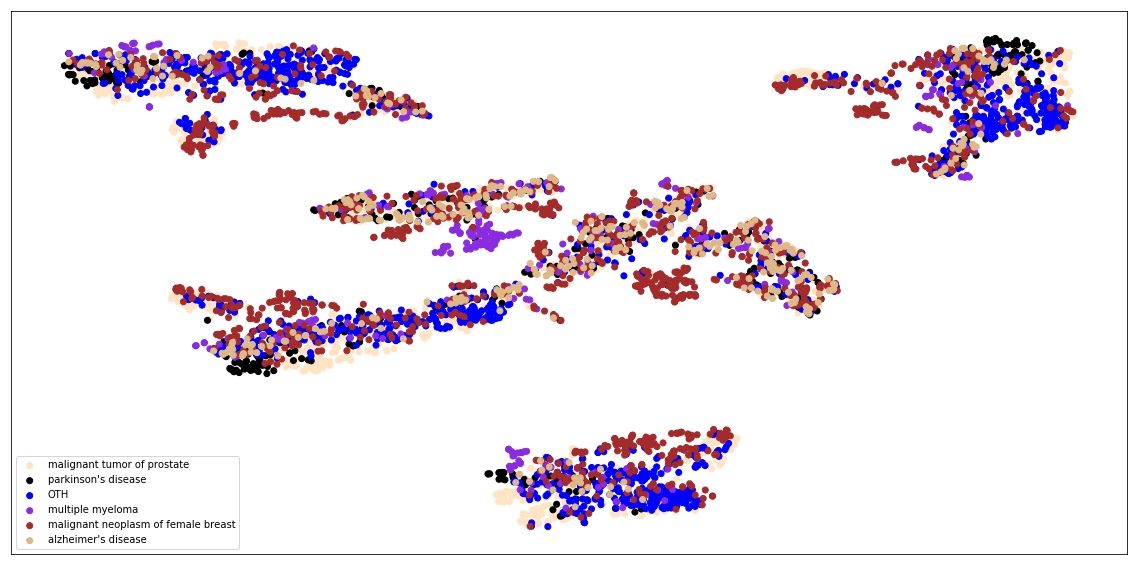

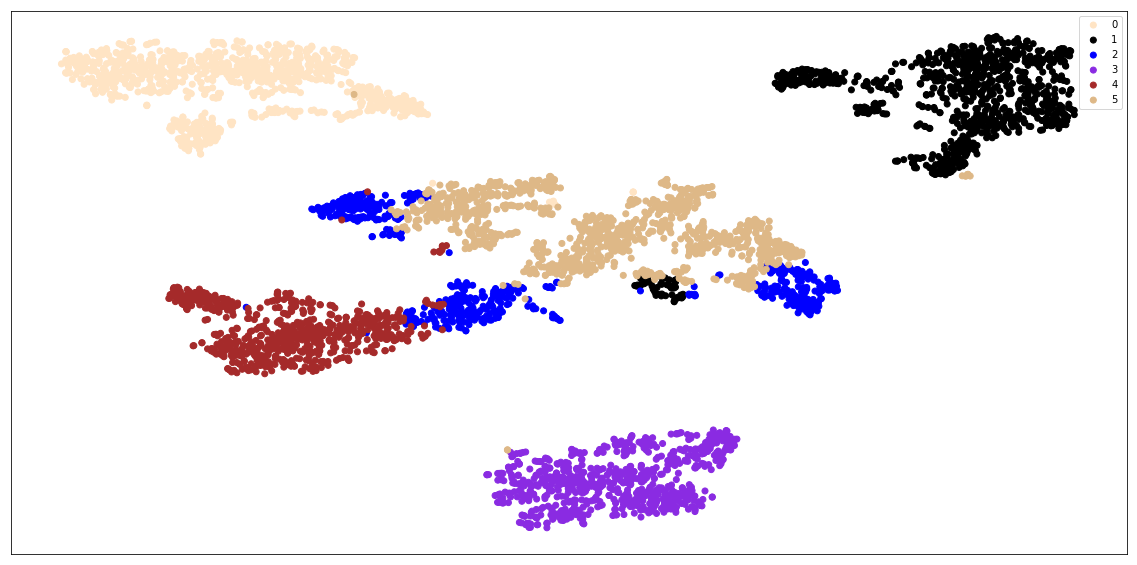

In [24]:
# plot data
colors_en1 = [colormap[disease_dict[v]] for v in disease_class_first]
single_plot(encoded_tsne, disease_class_first, colors_en1)

# plot cluster results
clusters = outer_clustering_analysis(encoded, disease_class_first)
colors_en2 = [colormap[v] for v in clusters]
single_plot(encoded_tsne, clusters, colors_en2)

### Raw Counts

In [25]:
# plot data
# colors_raw1 = [colormap[disease_dict[v]] for v in disease_class_first]
# single_plot(raw_tsne, disease_class_first, colors_raw1)

# plot cluster results
# clusters = outer_clustering_analysis(raw_data_scaled, gt_disease.values())
# colors_raw2 = [colormap[v] for v in clusters]
# single_plot(raw_tsne, clusters, colors_raw2)

### Tfidf matrix

Cluster: 0 -- Entropy: 2.376, Purity: 0.265
Max(p) disease: OTH
Cluster: 1 -- Entropy: 2.395, Purity: 0.259
Max(p) disease: OTH
Cluster: 2 -- Entropy: 2.430, Purity: 0.250
Max(p) disease: OTH
Cluster: 3 -- Entropy: 2.412, Purity: 0.257
Max(p) disease: OTH
Max(p) disease: malignant neoplasm of female breast
Cluster: 4 -- Entropy: 2.323, Purity: 0.296
Max(p) disease: OTH
Cluster: 5 -- Entropy: 2.369, Purity: 0.263
Max(p) disease: malignant tumor of prostate
Average Entropy: 2.39
Average Purity: 0.26


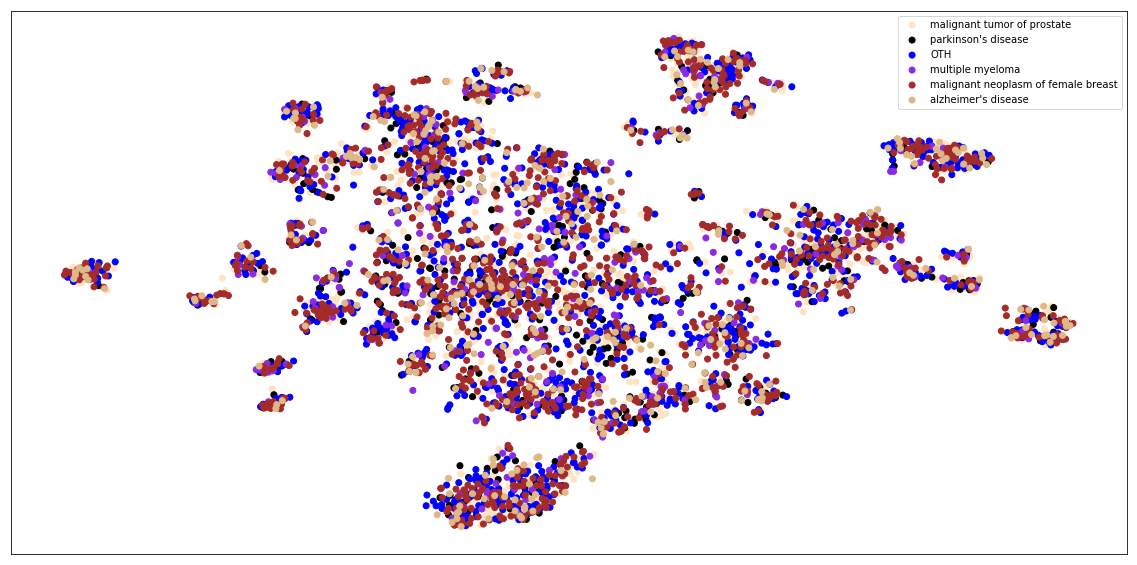

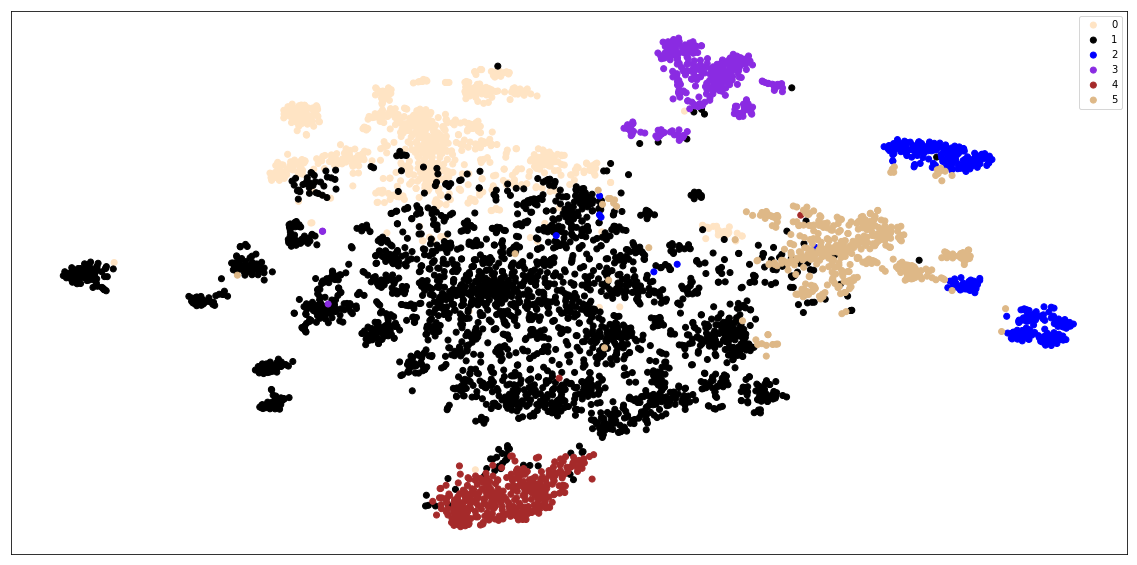

In [26]:
# plot data
colors_tfidf1 = [colormap[disease_dict[v]] for v in disease_class_first]
single_plot(tfidf_tsne, disease_class_first, colors_tfidf1)

# plot cluster results
clusters = outer_clustering_analysis(svd_mat, disease_class_first)
colors_tfidf2 = [colormap[v] for v in clusters]
single_plot(tfidf_tsne, clusters, colors_tfidf2)